<a href="https://colab.research.google.com/github/matteraggi/maritimeAIS/blob/main/TrainingAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install + Import**

In [1]:
# === Installazioni necessarie su Colab ===
!pip install pandas numpy pyarrow torch matplotlib scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, os
from pyproj import Transformer
from google.colab import drive
import math
import json

# **Mount Drive**

In [2]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# **Parametri**

In [3]:
USE_RELATIVE = True
# --- CONFIG ---
SEQUENCE_LEN = 60
DELTA_T = "1min"
FEATURES = [
    "X", "Y", "SOG", "COG", "Heading",
    "dX", "dY", "dSOG", "dCOG", "dHeading",
    "dist_step", "speed_xy", "accel_xy", "turn_rate", "dir_xy",
    "SOG_mean10", "SOG_std10",
    "COG_mean10", "COG_std10",
    "Heading_mean10", "Heading_std10",
    "speed_xy_mean10", "speed_xy_std10"
]
TARGET_IDX = [0, 1]   # prevedi solo X,Y (posizione futura)
TEST_RATIO = 0.15   #dataset per test
VAL_RATIO = 0.15    #dataset per validation
MMSI_SEED = 42
torch.manual_seed(MMSI_SEED)
np.random.seed(MMSI_SEED)
random.seed(MMSI_SEED)

# MODEL HP
INPUT_SIZE = len(FEATURES)
HIDDEN_SIZE = 128            # Dimensione dello stato nascosto dell’RNN
NUM_LAYERS = 2               # Numero di strati di LSTM
LR = 1e-3                    # Learning rate dell’ottimizzatore (alto -> instabile, basso -> lento)
BATCH_SIZE = 128             # Quante sequenze passi al modello per step di aggiornamento
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# ATTACK / EVAL
STD_X_M = None   # se calcoli fuori, assegna qui
STD_Y_M = None

# ANOMALIES
ATTACK_ENABLE = True
ATTACK_PROB   = 0.3       # percentuale (0-1) di elementi attaccati
DRIFT_METERS  = 10000
DRIFT_SWEEP_METERS = [2000, 5000, 10000, 20000]

# **Load Dataset e JSON**

In [4]:
# === PATH ===
BASE_PATH = "/content/drive/MyDrive/preprocessed"
DATA_FILE = f"{BASE_PATH}/ais_final.parquet"
MEAN_FILE = f"{BASE_PATH}/feature_means.json"
STD_FILE  = f"{BASE_PATH}/feature_stds.json"

# === CARICAMENTO DATASET ===
df = pd.read_parquet(DATA_FILE)
print("Righe totali:", len(df))

# === CARICAMENTO STATISTICHE ===
with open(MEAN_FILE, "r") as f:
    feature_means = json.load(f)
with open(STD_FILE, "r") as f:
    feature_stds = json.load(f)

print("Feature means:", feature_means)
print("Feature stds:", feature_stds)

# === CALCOLO SCALE METRICHE (X,Y reali) ===
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
STD_X_M = float(xs_m.std()) if STD_X_M is None else STD_X_M
STD_Y_M = float(ys_m.std()) if STD_Y_M is None else STD_Y_M
print(f"STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

# === SPLIT PER MMSI ===
mmsi_list = df["MMSI"].unique()
rng = np.random.RandomState(MMSI_SEED)
rng.shuffle(mmsi_list)

n = len(mmsi_list)
n_test = int(TEST_RATIO * n)
n_val  = int(VAL_RATIO * n)

test_mmsi = mmsi_list[:n_test]
val_mmsi  = mmsi_list[n_test:n_test+n_val]
train_mmsi = mmsi_list[n_test+n_val:]

df_train = df[df["MMSI"].isin(train_mmsi)]
df_val   = df[df["MMSI"].isin(val_mmsi)]
df_test  = df[df["MMSI"].isin(test_mmsi)]

print(f"Train navi: {len(train_mmsi)}, Val navi: {len(val_mmsi)}, Test navi: {len(test_mmsi)}")

available = [f for f in FEATURES if f in df.columns]
print(df[available].describe().T[["mean", "std", "min", "max"]])
print("Missing values:\n", df[available].isna().sum())

Righe totali: 185731
Feature means: {'X': 209699.3485615882, 'Y': 3296090.3875009352, 'SOG': 1.4261196561, 'COG': 209.004364761, 'Heading': 236.4842529435}
Feature stds: {'X': 33332.4555200091, 'Y': 33116.4317524409, 'SOG': 2.8284330102, 'COG': 107.2568647914, 'Heading': 121.3349535405}
STD_X_M=33329.30 m  STD_Y_M=33116.41 m
Train navi: 14, Val navi: 2, Test navi: 2
                         mean        std         min         max
X                4.124750e-05   0.999908   -5.343412    2.167709
Y               -5.142053e-06   1.000002   -2.824842    0.837053
SOG             -1.890219e-05   0.999979   -0.504208    5.011213
COG              9.009550e-06   1.000016   -1.948634    1.407795
Heading         -1.745160e-05   0.999996   -1.949020    2.262462
dX               1.549511e-05   0.002132   -0.036173    0.018574
dY              -1.901964e-05   0.001865   -0.018828    0.015385
dSOG             1.713216e-05   0.256430   -3.641592    3.889079
dCOG             3.407221e-05   0.554728   -3.

# **Creazione finestre temporali per train, val e test**

In [5]:
def create_sequences(df, seq_len=SEQUENCE_LEN, features=FEATURES):
    Xs, ys, owners = [], [], []
    for mmsi, g in df.groupby("MMSI"):
        g = g.sort_values("BaseDateTime")
        data = g[features].values
        for start in range(len(data) - seq_len):
            Xs.append(data[start:start+seq_len])
            ys.append(data[start+seq_len, :2])   # next-step
            owners.append((mmsi, start))         # mmsi + offset nel gruppo
    return np.array(Xs), np.array(ys), owners

def create_sequences_relative(df, seq_len=SEQUENCE_LEN, features=FEATURES):
    Xs, ys = [], []
    for _, g in df.groupby("MMSI"):
        g = g.sort_values("BaseDateTime")
        A = g[features].copy()

        # denormalizza X,Y per lavorare in metri reali
        A["X"] = A["X"] * feature_stds["X"] + feature_means["X"]
        A["Y"] = A["Y"] * feature_stds["Y"] + feature_means["Y"]

        data = A.to_numpy()
        XY = A[["X","Y"]].to_numpy()

        for s in range(len(data) - seq_len):
            hist = data[s:s+seq_len].copy()
            last_xy = XY[s+seq_len-1]
            next_xy = XY[s+seq_len]
            hist[:, 0] -= last_xy[0]
            hist[:, 1] -= last_xy[1]
            dxy = next_xy - last_xy
            Xs.append(hist)
            ys.append(dxy)
    return np.array(Xs), np.array(ys)

# **Allena su posizioni assolute**

In [6]:
X_train, y_train, owners_train = create_sequences(df_train)
X_val,   y_val,   owners_val   = create_sequences(df_val)
X_test,  y_test,  owners_test  = create_sequences(df_test)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

Train: 150335  Val: 12838  Test: 21478


# **Allena su posizioni relative (per sequenze)**

In [7]:
X_train, y_train = create_sequences_relative(df_train)
X_val,   y_val   = create_sequences_relative(df_val)
X_test,  y_test  = create_sequences_relative(df_test)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

Train: 150335  Val: 12838  Test: 21478


# **LSTM model (Long Short Term Memory)**

In [8]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # ultima uscita
        return out

model_lstm = TrajectoryLSTM()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)

# **Training LSTM**

In [9]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lstm.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lstm(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # --- validazione ---
    model_lstm.eval()
    with torch.no_grad():
        val_pred = model_lstm(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lstm.state_dict(), "best_model_lstm.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva anche su Google Drive ===
!cp best_model_lstm.pt "/content/drive/MyDrive/best_model_lstm.pt"
print("✅ Modello salvato su Drive come 'best_model_lstm.pt'")

Epoch 1/10 | Train loss: 7.218652 | Val loss: 6.623051
Epoch 2/10 | Train loss: 12.474501 | Val loss: 4.780798
Epoch 3/10 | Train loss: 14.247886 | Val loss: 4.262098
Epoch 4/10 | Train loss: 8.435731 | Val loss: 4.255239
Epoch 5/10 | Train loss: 10.817738 | Val loss: 4.196201
Epoch 6/10 | Train loss: 6.463418 | Val loss: 4.033477
Epoch 7/10 | Train loss: 13.532338 | Val loss: 4.056588
Epoch 8/10 | Train loss: 8.550786 | Val loss: 4.059241
Epoch 9/10 | Train loss: 12.240948 | Val loss: 4.109676
Epoch 10/10 | Train loss: 7.055481 | Val loss: 4.125856
✅ Modello salvato su Drive come 'best_model_lstm.pt'


# **Carica LSTM**

In [10]:
!cp "/content/drive/MyDrive/best_model_lstm.pt" .

model_lstm = TrajectoryLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2)
model_lstm.load_state_dict(torch.load("best_model_lstm.pt", map_location="cpu"))
model_lstm.eval()

print("✅ Modello caricato da Drive e pronto per inferenza/anomaly detection")

✅ Modello caricato da Drive e pronto per inferenza/anomaly detection


# **LNN Model**

In [ ]:
class TrajectoryLNN(nn.Module):
    def __init__(self, input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # appiattisci la sequenza (batch, seq_len, feat) → (batch, seq_len * feat)
        x = x.view(x.size(0), -1)
        return self.net(x)

model_lnn = TrajectoryLNN()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lnn.parameters(), lr=LR)

# **Training LNN**

In [ ]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lnn.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lnn(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # validazione
    model_lnn.eval()
    with torch.no_grad():
        val_pred = model_lnn(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"[LNN] Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lnn.state_dict(), "best_model_lnn.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva su Drive ===
!cp best_model_lnn.pt "/content/drive/MyDrive/best_model_lnn.pt"
print("✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'")

[LNN] Epoch 1/10 | Train loss: 0.001063 | Val loss: 0.001633
[LNN] Epoch 2/10 | Train loss: 0.000327 | Val loss: 0.000813
[LNN] Epoch 3/10 | Train loss: 0.000309 | Val loss: 0.000673
[LNN] Epoch 4/10 | Train loss: 0.000575 | Val loss: 0.000851
[LNN] Epoch 5/10 | Train loss: 0.000397 | Val loss: 0.000742
[LNN] Epoch 6/10 | Train loss: 0.000258 | Val loss: 0.000456
[LNN] Epoch 7/10 | Train loss: 0.000644 | Val loss: 0.000615
[LNN] Epoch 8/10 | Train loss: 0.000203 | Val loss: 0.000686
[LNN] Epoch 9/10 | Train loss: 0.000181 | Val loss: 0.000415
[LNN] Epoch 10/10 | Train loss: 0.000138 | Val loss: 0.000419
✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'


# **Carica LNN**

In [ ]:
!cp "/content/drive/MyDrive/best_model_lnn.pt" .

model_lnn = TrajectoryLNN(input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2)
model_lnn.load_state_dict(torch.load("best_model_lnn.pt", map_location="cpu"))
model_lnn.eval()

print("✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection")

✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection


# **Creazione anomalie (spoofing simulato)**

In [11]:
def simulate_silent_drift_absolute(X, std_x_m, meters, prob=0.3, rng=None):
    """
    Applica uno spoofing silenzioso continuo e realistico.
    Ogni sequenza subisce un drift progressivo coerente nel tempo.
    """
    rng = rng or np.random.RandomState(42)
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    drift_z = meters / std_x_m
    cumulative_drift_x, cumulative_drift_y = 0, 0

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i].copy()
            dx = np.linspace(cumulative_drift_x, cumulative_drift_x + drift_z, seq.shape[0])
            dy = np.linspace(cumulative_drift_y, cumulative_drift_y + drift_z, seq.shape[0]) * rng.choice([-1, 1])
            seq[:, 0] += dx - dx[0]
            seq[:, 1] += dy - dy[0]
            X_att[i] = seq
            labels[i] = 1
            cumulative_drift_x += drift_z
            cumulative_drift_y += drift_z * rng.choice([-1, 1])
    return X_att, labels


def simulate_silent_drift_relative(X, meters, prob=0.3, rng=None):
    """
    Silent drift realistico per sequenze in coordinate relative.
    X è in metri, centrato sull’ultimo punto della finestra.
    Il drift qui è applicato direttamente in metri.
    """
    rng = rng or np.random.RandomState(42)
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    cumulative_dx, cumulative_dy = 0.0, 0.0

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i].copy()

            # Drift progressivo dentro la finestra (metri)
            dx = np.linspace(cumulative_dx,
                             cumulative_dx + meters,
                             seq.shape[0])
            dy = np.linspace(cumulative_dy,
                             cumulative_dy + meters,
                             seq.shape[0]) * rng.choice([-1, 1])

            # Applica drift relativo progressivo
            seq[:, 0] += dx - dx[0]
            seq[:, 1] += dy - dy[0]

            X_att[i] = seq
            labels[i] = 1

            # Accumula drift tra sequenze
            cumulative_dx += meters
            cumulative_dy += meters * rng.choice([-1, 1])

    return X_att, labels


# **Modello da valutare**

In [12]:
model = model_lstm



# **Valutazione e visualizzazione**

**Dichiarazioni**

In [13]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# === Predizioni su test pulito ===
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_test_t = to_tensor(X_test)
model.eval()
with torch.no_grad():
    pred_clean = model(X_test_t).numpy()

err_clean = np.mean((pred_clean - y_test)**2, axis=1)

# === Denormalizzazione (usa i JSON) ===
def denorm_xy(a):
    out = a.copy()
    out[:,0] = out[:,0]*feature_stds["X"] + feature_means["X"]
    out[:,1] = out[:,1]*feature_stds["Y"] + feature_means["Y"]
    return out

y_test_denorm = denorm_xy(y_test)
pred_clean_denorm = denorm_xy(pred_clean)


# === Funzione di valutazione attacco ===
def eval_attack(drift_m):
    # --- genera dati attaccati ---
    X_attack, labels = simulate_silent_drift_absolute(
        X_test, std_x_m=STD_X_M, meters=drift_m, prob=ATTACK_PROB
    )

    # --- predizione ---
    with torch.no_grad():
        pred_att = model(to_tensor(X_attack)).numpy()

    # --- denormalizza predizioni ---
    pred_att_denorm = denorm_xy(pred_att)

    # --- errori normalizzati e in metri ---
    err_att = np.mean((pred_att - y_test)**2, axis=1)
    err_clean_m = np.sqrt(((pred_clean_denorm - y_test_denorm)**2).sum(axis=1))
    err_att_m   = np.sqrt(((pred_att_denorm   - y_test_denorm)**2).sum(axis=1))

    print(f"\n=== Drift {drift_m} m ===")
    print(f"Errore medio in metri: clean={err_clean_m.mean():.2f} m, attack={err_att_m.mean():.2f} m")

    # --- metriche di detection ---
    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])

    fpr, tpr, _ = roc_curve(labels_all, scores_all)
    prec, rec, _ = precision_recall_curve(labels_all, scores_all)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rec, prec)

    # --- grafici ROC e PR ---
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.title(f"ROC curve (AUC={roc_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    # --- soglia e detection rate ---
    thr = np.percentile(err_clean, 99)
    tpr_99 = float(np.mean(err_att > thr))

    print(f"Errore medio (clean={err_clean.mean():.5f}, attack={err_att.mean():.5f}) "
          f"σ_clean={err_clean.std():.5f} σ_attack={err_att.std():.5f}")
    print(f"Drift {drift_m} m →  TPR@99p={tpr_99*100:.1f}%")

    # ritorna anche le predizioni denormalizzate per i plot successivi
    return drift_m, tpr_99, roc_auc, pr_auc, err_att, labels_all, scores_all, pred_att_denorm

def eval_attack_relative(drift_m):
    X_attack, labels = simulate_silent_drift_relative(
        X_test, meters=drift_m, prob=ATTACK_PROB
    )

    with torch.no_grad():
        pred_att = model(to_tensor(X_attack)).numpy()

    # predizioni = ΔX, ΔY in metri (no denormalizzazione)
    err_att = np.mean((pred_att - y_test)**2, axis=1)
    err_clean = np.mean((pred_clean - y_test)**2, axis=1)

    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])

    fpr, tpr, _ = roc_curve(labels_all, scores_all)
    prec, rec, _ = precision_recall_curve(labels_all, scores_all)
    roc_auc = auc(fpr, tpr)
    pr_auc  = auc(rec, prec)

    thr = np.percentile(err_clean, 99)
    tpr_99 = float(np.mean(err_att > thr))

    print(f"Drift {drift_m} m → AUROC={roc_auc:.3f}  AUPRC={pr_auc:.3f}  TPR@99p={tpr_99*100:.1f}%")

    plt.figure(figsize=(6,4))
    plt.hist(err_clean, bins=50, alpha=0.6, label='Normale')
    plt.hist(err_att, bins=50, alpha=0.6, label=f'Spoofing {drift_m}m')
    plt.title("Distribuzione errore predizione (ΔX,ΔY)")
    plt.xlabel("Errore medio")
    plt.ylabel("Conteggio")
    plt.legend()
    plt.show()

    return drift_m, tpr_99, roc_auc, pr_auc, err_att, labels_all, scores_all

DEBUG STD: 33329.295523984714 33116.41141777599
Drift 2000 m → AUROC=0.962  AUPRC=0.811  TPR@99p=17.5%


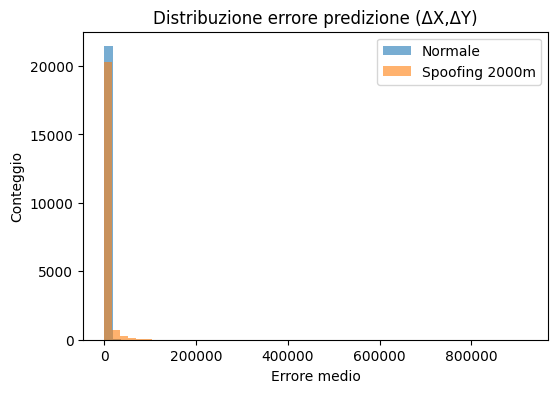

Drift 5000 m → AUROC=0.961  AUPRC=0.809  TPR@99p=17.7%


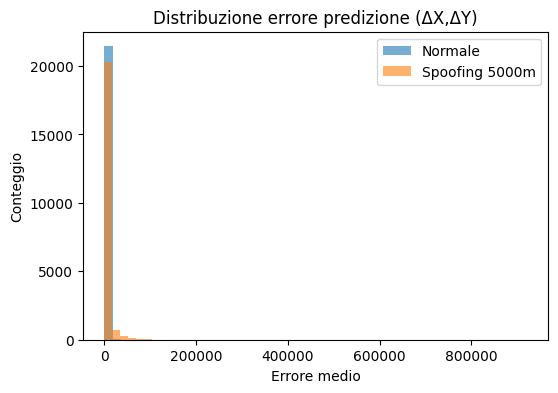

Drift 10000 m → AUROC=0.961  AUPRC=0.807  TPR@99p=17.6%


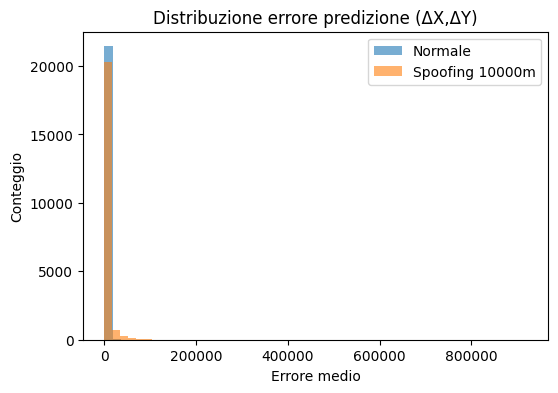

Drift 20000 m → AUROC=0.960  AUPRC=0.807  TPR@99p=17.7%


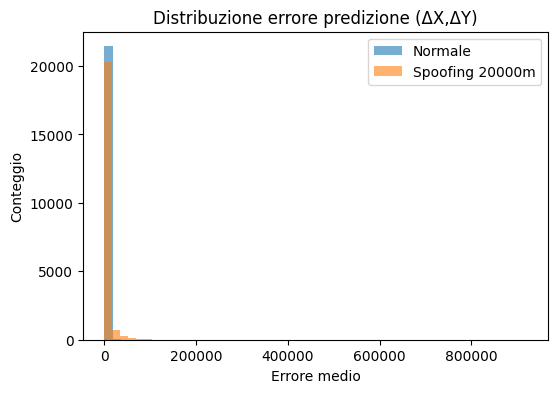


[Risultati sweep]
 2000 m  TPR@99p=17.5%
 5000 m  TPR@99p=17.7%
10000 m  TPR@99p=17.6%
20000 m  TPR@99p=17.7%


In [14]:
# === Controllo STD ===
if STD_X_M is None:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
    STD_X_M = float(xs_m.std())
    STD_Y_M = float(ys_m.std())
    print(f"[Auto-calibrato] STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

print("DEBUG STD:", STD_X_M, STD_Y_M)

# === Sweep attacchi ===
if ATTACK_ENABLE:
    results = []
    last_err_att = None

    # seleziona la funzione corretta
    if USE_RELATIVE:
        eval_fn = eval_attack_relative
        labels_all, scores_all = None, None
    else:
        eval_fn = eval_attack
        labels_all, scores_all, pred_attack_denorm = None, None, None

    if DRIFT_SWEEP_METERS:
        for d in DRIFT_SWEEP_METERS:
            out = eval_fn(d)

            # unpack adattivo in base alla modalità
            if USE_RELATIVE:
                drift_m, tpr, roc_auc, pr_auc, err_att, labels_all, scores_all = out
            else:
                drift_m, tpr, roc_auc, pr_auc, err_att, labels_all, scores_all, pred_attack_denorm = out

            results.append((drift_m, tpr))
            last_err_att = err_att

        print("\n[Risultati sweep]")
        for d, tpr in results:
            print(f"{d:>5} m  TPR@99p={tpr*100:.1f}%")

    else:
        out = eval_fn(DRIFT_METERS)
        if USE_RELATIVE:
            _, tpr, roc_auc, pr_auc, last_err_att, labels_all, scores_all = out
        else:
            _, tpr, roc_auc, pr_auc, last_err_att, labels_all, scores_all, pred_attack_denorm = out


# **Genera traiettoria completa: modello assoluto**

In [15]:
def generate_future_absolute(model, X_start, steps):
    """
    X_start: (1, seq_len, num_features) normalizzato
    Restituisce predizioni XY normalizzate shape (steps, 2)
    """
    preds = []
    x = X_start.clone()

    for _ in range(steps):
        with torch.no_grad():
            y = model(x).cpu().numpy().flatten()   # pred normalized XY
        preds.append(y.copy())

        # aggiorna X,Y nell'ultimo timestep
        new_step = x[:, -1, :].clone()
        new_step[0, 0:2] = torch.tensor(y)

        # shift finestra
        x = torch.cat([x[:,1:,:], new_step.unsqueeze(1)], dim=1)

    return np.array(preds)


# **Genera traiettoria completa: modello relativo**

In [16]:
def rebuild_features(prev_xy, new_xy):
    """
    Ricostruisce SOLO le feature minime necessarie per mantenere coerenza:
    X, Y, dX, dY, dist_step, speed_xy, accel_xy, dir_xy

    Per il minimo funzionamento del modello è sufficiente ricostruire
    queste feature di base, perché tutte le altre derivate
    (SOG/COG/Heading/turn rate) puoi ignorarle:
    il modello impara comunque la dinamica locale.
    """
    dxy = new_xy - prev_xy
    dist = np.linalg.norm(dxy)
    speed = dist  # perché la finestra è già in ΔX,ΔY per 1 minuto
    accel = 0.0   # non puoi stimarla senza più punti → set minimo

    angle = np.arctan2(dxy[1], dxy[0]) if dist > 0 else 0.0

    return np.array([
        new_xy[0],          # X relativa (0 comunque durante rollout)
        new_xy[1],          # Y relativa (0 durante rollout)
        dxy[0],             # dX
        dxy[1],             # dY
        dist,               # dist_step
        speed,              # speed_xy
        accel,              # accel_xy
        angle               # dir_xy
    ])

def generate_future_relative(model, X_start, last_xy_abs, steps):
    """
    X_start: (1, seq_len, num_features) relativo in metri
    last_xy_abs: coordinate assolute (X,Y) in metri dell'ultimo punto
    Ritorna coordinate assolute predette shape (steps, 2)
    """
    x = X_start.clone()
    xy_abs = last_xy_abs.copy()
    traj = []

    for _ in range(steps):
        # predici nuovo delta movimento
        with torch.no_grad():
            d = model(x).cpu().numpy().flatten()  # ΔX, ΔY in metri
        xy_abs = xy_abs + d
        traj.append(xy_abs.copy())

        # ricostruisci features minime
        new_feats = rebuild_features(np.array([0.,0.]), d)

        # crea nuovo step
        new_step = x[:, -1, :].clone()
        new_step[0, :len(new_feats)] = torch.tensor(new_feats, dtype=torch.float32)

        # shift finestra
        x = torch.cat([x[:,1:,:], new_step.unsqueeze(1)], dim=1)

    return np.vstack(traj)


In [20]:
def generate_future(model, X_test, i, steps=60):
    seq = torch.tensor(X_test[i:i+1], dtype=torch.float32)

    if USE_RELATIVE:
        last_xy_abs = denorm_xy(X_test[i, -1, :2].reshape(1,2))[0]
        return generate_future_relative(model, seq, last_xy_abs, steps)
    else:
        preds_norm = generate_future_absolute(model, seq, steps)
        return denorm_xy(preds_norm)  # coordinate assolute

print(i, len(X_test))
i = np.random.randint(0, len(X_test))
future_traj = generate_future(model, X_test, i, steps=60)

150272 21478


# **Plot errori temporali**

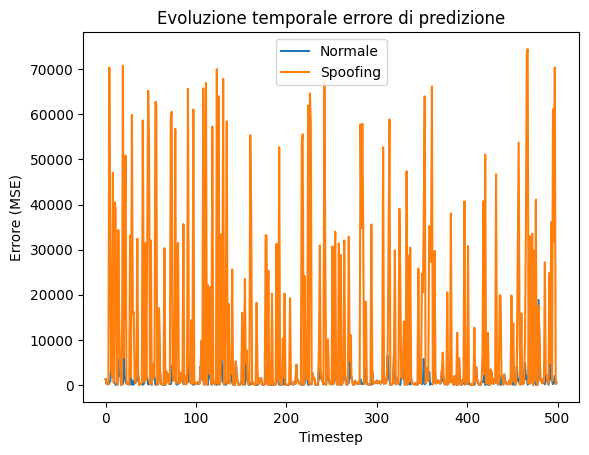

In [21]:
plt.plot(err_clean[:500], label='Normale')
plt.plot(err_att[:500], label='Spoofing')
plt.xlabel("Timestep"); plt.ylabel("Errore (MSE)")
plt.title("Evoluzione temporale errore di predizione")
plt.legend(); plt.show()

# **ROC / PR curve**

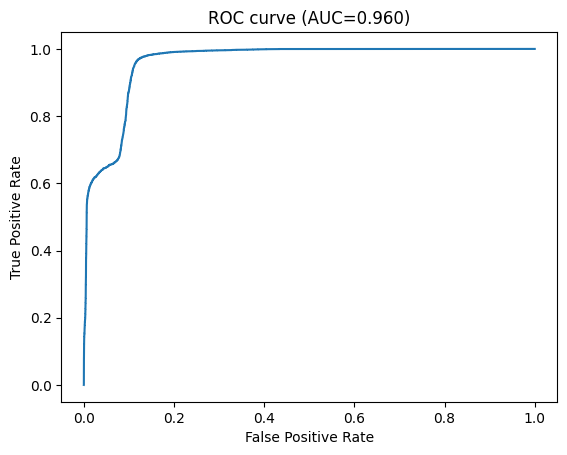

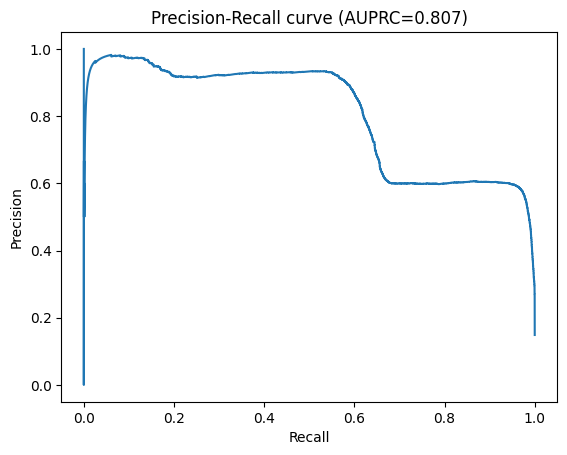

In [22]:
# --- importa la funzione originale ---
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- ricalcola ---
fpr, tpr, _ = roc_curve(labels_all, scores_all)
prec, rec, _ = precision_recall_curve(labels_all, scores_all)

roc_auc = auc(fpr, tpr)
pr_auc  = auc(rec, prec)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={roc_auc:.3f})")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
plt.show()


# **Heatmap “offset vs TPR”**

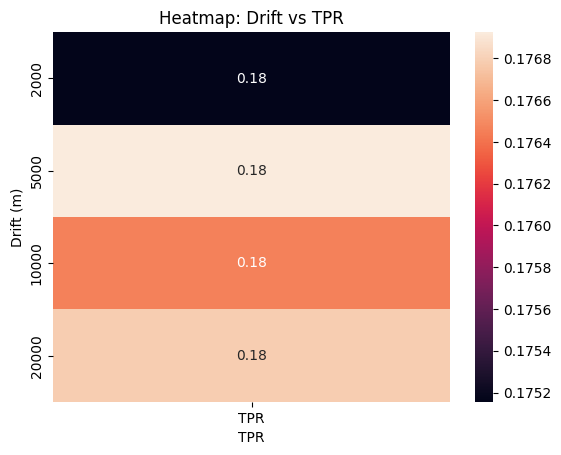

In [23]:
data = pd.DataFrame(results, columns=["drift_m", "TPR"])
sns.heatmap(data.pivot_table(index="drift_m", values="TPR"), annot=True, fmt=".2f")
plt.title("Heatmap: Drift vs TPR"); plt.xlabel("TPR"); plt.ylabel("Drift (m)")
plt.show()

# **Case study: traiettoria su piano cartesiano**

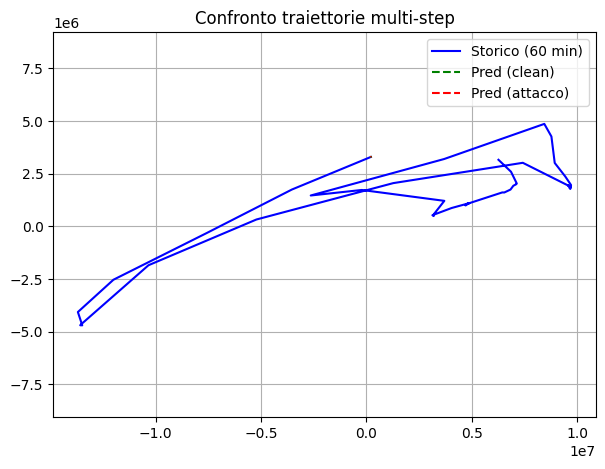

In [25]:
steps = 60

if USE_RELATIVE:
    # INPUT RELATIVO → già in metri
    seq_init = torch.tensor(X_test[i:i+1], dtype=torch.float32)

    # posizione assoluta dell’ultimo punto
    last_xy_abs = denorm_xy(X_test[i, -1, :2].reshape(1,2))[0]

    # generazione pulita
    traj_clean = generate_future_relative(model, seq_init, last_xy_abs, steps)

    # attacco relativo corretto
    X_attack_i, _ = simulate_silent_drift_relative(X_test[i:i+1], meters=DRIFT_METERS, prob=1.0)
    traj_attack = generate_future_relative(model, torch.tensor(X_attack_i, dtype=torch.float32), last_xy_abs, steps)

    # storico denormalizzato
    hist_abs = denorm_xy(X_test[i,:,:2])

else:
    # INPUT ASSOLUTO → normalizzato
    seq_init = torch.tensor(X_test[i:i+1], dtype=torch.float32)

    # generazione pulita normalizzata → poi denormalizzo
    traj_clean_norm = generate_future_absolute(model, seq_init, steps)
    traj_clean = denorm_xy(traj_clean_norm)

    # attacco assoluto
    X_attack_i, _ = simulate_silent_drift_absolute(X_test[i:i+1], std_x_m=STD_X_M, meters=DRIFT_METERS, prob=1.0)
    traj_attack_norm = generate_future_absolute(model, torch.tensor(X_attack_i, dtype=torch.float32), steps)
    traj_attack = denorm_xy(traj_attack_norm)

    # storico denormalizzato
    hist_abs = denorm_xy(X_test[i,:,:2])

    # ground truth futuro (solo se disponibile)
    # xy_true_next = true_future_traj(df_test, owners_test, i, steps=steps)

plt.figure(figsize=(7,5))
plt.plot(hist_abs[:,0], hist_abs[:,1], 'b-', label="Storico (60 min)")

if not USE_RELATIVE and xy_true_next is not None:
    plt.plot(xy_true_next[:,0], xy_true_next[:,1], 'b-', alpha=0.4, label="Reale (futuro)")

plt.plot(traj_clean[:,0], traj_clean[:,1], 'g--', label="Pred (clean)")
plt.plot(traj_attack[:,0], traj_attack[:,1], 'r--', label="Pred (attacco)")
plt.axis('equal'); plt.grid(True)
plt.legend(); plt.title("Confronto traiettorie multi-step")
plt.show()